In [1]:
import threading
import multiprocessing
import psutil
import shelve
import pickle
import sys
import h5py
import csv
import os
import gc
import shutil
import seaborn as sns
import pandas as pd
import numpy as np
import decimal
from pyneuroml import pynml
from pyneuroml.pynml import print_comment_v
from pyneuroml.lems import LEMSSimulation
from numpy import *
import neuroml as nml
import neuroml.writers as writers
from neuroml.utils import validate_neuroml2
import random
random.seed(12345)
from neuroml.nml.nml import parse as nmlparse
import eden_tools
dir(eden_tools)

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
os.getcwd()

print(f'Threads: {threading.active_count()}')
print('RAM memory % used:', psutil.virtual_memory()[2])

Threads: 5
RAM memory % used: 14.1


/opt/conda/lib/python3.7/site-packages/airspeed/__init__.py:505: FutureWarning: Possible nested set at position 8
  KEYVALSEP = re.compile(r'[ \t]*:[[ \t]*(.*)$', re.S)


In [2]:
path = os.getcwd()
cell_id = 'C51A'
Temp = 37
net_id = "network_of_%s"%cell_id    
net_doc = nml.NeuroMLDocument(id='net_'+str(cell_id))
results = []
channel_dict = dict(na_s_soma=0, kdr_soma=1, k_soma=2, cal_soma=3, BK_soma=4, cah_dend=5, kca_dend=6, h_dend=7, cacc_dend=8, na_axon=9, k_axon=10)



In [3]:
def LEMS(b,amp):
    
    
    #include cell file from ../Cells/
    net_doc = nml.NeuroMLDocument(id='net_'+str(cell_id)+str(b))
    cellfile = nml.IncludeType(href='../Cells/'+cell_id+str(b)+'_scaled_exp_resample_5.cell.nml')
    net_doc.includes.append(cellfile)

    #create network
    net = nml.Network(id=net_id, type="networkWithTemperature", temperature=str(Temp)+"degC")
    net_doc.networks.append(net)

    #create population
    pop = nml.Population(id='population_of_%s'%cell_id,component=cell_id,type='populationList',size='1')
    net.populations.append(pop)

    loc = nml.Location(x='0',y='0',z='0')
    inst = nml.Instance(id='0',location=loc)
    pop.instances.append(inst)

    #include current clamp 
    t_delay = 50
    t_duration = 250
    Amp = f'-{amp}nA'

    Iclamp0 = nml.PulseGenerator(id='iclamp0',delay=str(t_delay)+'ms',duration=str(t_duration)+'ms', amplitude=Amp)
    net_doc.pulse_generators.append(Iclamp0)

    Iclamp1 = nml.PulseGenerator(id='iclamp1',delay=str(t_delay)+'ms',duration=str(t_duration)+'ms', amplitude=Amp)
    net_doc.pulse_generators.append(Iclamp1)


    #add Iclamp to cell
    #input_list = nml.InputList(id='Iclamp0', component=Iclamp0.id, populations=pop.id)
    #input = nml.Input(id='0', target = "../%s/0/"%(pop.id)+str(cell_id), segmentId="0", destination="synapses")
    #input_list.input.append(input)
    #net.input_lists.append(input_list)

    #change segment_id to change the compartment you stimulate
    input_list = nml.InputList(id='Iclamp1', component=Iclamp1.id, populations=pop.id)
    input = nml.Input(id='0', target = "../%s/0/"%(pop.id)+str(cell_id), segmentId="0", destination="synapses")
    input_list.input.append(input)
    input = nml.Input(id='1', target = "../%s/0/"%(pop.id)+str(cell_id), segmentId="0", destination="synapses")
    input_list.input.append(input)
    net.input_lists.append(input_list)



    #write the network file
    net_file_name = 'nml_'+cell_id+str(b)+'.net.nml'
    writers.NeuroMLWriter.write(net_doc,net_file_name)
    shutil.move(path+'/'+str(net_file_name), path+'/pynmlNetworks')
    
    #redefine net and cell in case you don't run the above code segment
    sim_id = 'Test'
    length = 10000
    step = 0.025

    dend_channel = ["cah_dend/cah/r/q", "kca_dend/kca/z/q", "h_dend/h/n/q", "cacc_dend/cacc/m/q"]
    axon_channel = ["na_axon/na_a/m/q", "na_axon/na_a/h/q", "k_axon/k/n/q"]
    soma_channel = ["na_s_soma/na_s/m/q", "na_s_soma/na_s/h/q", "kdr_soma/kdr/n/q", "k_soma/k/n/q", "cal_soma/cal/k/q", "cal_soma/cal/l/q", "BK_soma/BK/c/q"]
    recorded_segment = 0
    recorded_segment1 = 69
    recorded_segment2 = 8
    recorded_segment3 = 0
    recorded_variable1 = "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment1)+"/v"
    recorded_variable2 = "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment2)+"/v"
    recorded_variable3 = "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment3)+"/v"

    nmlfile = './pynmlNetworks/nml_'+cell_id+str(b)+'.net.nml'  #include_neuroml2_file duplicates the path if you use path+ and does not find the file if you use ../
    LEMS = LEMSSimulation(sim_id, length , step , target = "network_of_%s"%cell_id)
    LEMS.include_neuroml2_file(nmlfile)
    #LEMS.set_report_file('SimStat.txt')                                   # not necessary but out of interest to see EDEN vs NEURON 




    #disp_0 = 'Voltage'
    #LEMS.create_display(disp_0, 'Voltage trace', '-100', '70' )
    #LEMS.add_line_to_display(disp_0, recorded_segment, recorded_variable)

    #traces0 = 'voltage traces'
    #LEMS.create_output_file(traces0,"%s.v.dat"%sim_id)
    #LEMS.add_column_to_output_file(traces0, recorded_segment, recorded_variable)
    #disp1 = 'Gates Dendrite'
    #disp2 = 'Gates Axon'
    #disp = 'Gates Soma'
    #traces1 = 'Gate_file_dendrite'
    #traces2 = 'Gate_file_axon'
    #traces = 'Gate_file_soma'

    #LEMS.create_display(disp, "Soma gate variables", "0", "1")
    #LEMS.create_output_file(traces, "%s.Soma_gates.dat"%sim_id)

    #LEMS.create_display(disp1, "Dendrite gate variables", "0", "1")
    #LEMS.create_output_file(traces1, "%s.Dendrite_gates.dat"%sim_id)

    #LEMS.create_display(disp2, "Axon gate variables", "0", "1")
    #LEMS.create_output_file(traces2, "%s.Axon_gates.dat"%sim_id)

    #for i in range(len(dend_channel)):
        #disp1 = 'Gates Dendrite'
        #LEMS.create_display(disp1, "Dendrite gate variables", "0", "1")
       # LEMS.add_line_to_display(disp1, recorded_segment1, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment1)+"/biophys/membraneProperties/"+str(dend_channel[i]))

        #traces1 = 'Gate_file_dendrite'
        #LEMS.create_output_file(traces1, "%s.gates.dat"%sim_id)
       # LEMS.add_column_to_output_file(traces1, recorded_segment1, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment1)+"/biophys/membraneProperties/"+str(dend_channel[i]))

    #for i in range(len(axon_channel)):
        #disp2 = 'Gates Axon'
        #LEMS.create_display(disp1, "Dendrite gate variables", "0", "1")
       # LEMS.add_line_to_display(disp2, recorded_segment2, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment2)+"/biophys/membraneProperties/"+str(axon_channel[i]))

        #traces2 = 'Gate_file_axon'
        #LEMS.create_output_file(traces1, "%s.gates.dat"%sim_id)
     #   LEMS.add_column_to_output_file(traces2, recorded_segment2, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment2)+"/biophys/membraneProperties/"+str(axon_channel[i]))   

    #for i in range(len(soma_channel)):
        #disp2 = 'Gates Axon'
        #LEMS.create_display(disp1, "Dendrite gate variables", "0", "1")
    #    LEMS.add_line_to_display(disp, recorded_segment, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment)+"/biophys/membraneProperties/"+str(soma_channel[i]))

        #traces2 = 'Gate_file_axon'
        #LEMS.create_output_file(traces1, "%s.gates.dat"%sim_id)
    #    LEMS.add_column_to_output_file(traces, recorded_segment, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment)+"/biophys/membraneProperties/"+str(soma_channel[i]))        



    disp4 = 'Voltage'
    LEMS.create_display(disp4, "Dendrite trace", "-100", "70")
    LEMS.add_line_to_display(disp4, recorded_segment1, recorded_variable1)
    LEMS.add_line_to_display(disp4, recorded_segment2, recorded_variable2)
    LEMS.add_line_to_display(disp4, recorded_segment3, recorded_variable3)

    traces4 = 'file'
    LEMS.create_output_file(traces4, "%s.vd.dat"%sim_id)
    LEMS.add_column_to_output_file(traces4, recorded_segment1, recorded_variable1)
    LEMS.add_column_to_output_file(traces4, recorded_segment2, recorded_variable2)
    LEMS.add_column_to_output_file(traces4, recorded_segment3, recorded_variable3)

    #disp5 = 'Caconc'
    #LEMS.create_display(disp5, "Caconc trace", "-100", "70")
    #LEMS.add_line_to_display(disp5, recorded_segment1, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(69)+"/caConc")

    #traces5 = 'Caconc file'
    #LEMS.create_output_file(traces5, "%s.caconc.dat"%sim_id)
    #LEMS.add_column_to_output_file(traces5, recorded_segment1, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(69)+"/caConc")


    #disp5 = 'Calcium Concentration'
    #LEMS.create_display(disp5, "Calcium concentration", "0", "1")
    #LEMS.add_line_to_display(disp, recorded_segment, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment)+"/caConc")

    #traces5 = 'Ca conc file'
    #LEMS.create_output_file(traces5, "%scalconc.dat"%sim_id)
    #LEMS.add_column_to_output_file(traces5, recorded_segment, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment)+"/caConc")        







    filename = 'LEMS_'+str(sim_id)+'_'+str(cell_id)+str(b)+'.xml'
    LEMS.save_to_file(file_name = filename )

    #edit the wrong path generated by LEMS.include_neuroml2_file
    fin = open(path+'/'+str(filename), 'rt')
    data = fin.read()
    data = data.replace('<Include file="./pynmlNetworks/', '<Include file="../pynmlNetworks/')
    data = data.replace('ExpTime.nml', '../channels/ExpTime.nml')    # patch up for wrong path generated in network script
    fin.close()
    fin = open(path+'/'+str(filename), 'wt')
    fin.write(data)
    fin.close()
    if not os.path.exists(f'LEMSFILES{b}'):
        os.mkdir(f'LEMSFILES{b}')
    shutil.move(path+'/'+str(filename), path+'/LEMSFILES'+str(b))
    

In [4]:
sim_id = 'Test'
for f in range(6):
    if os.path.exists(f'./pynmlNetworks/nml_{cell_id}{f}.net.nml'):
        os.remove(f'./pynmlNetworks/nml_{cell_id}{f}.net.nml')
        os.remove(f'./LEMSFILES{f}/LEMS_{sim_id}_{cell_id}{f}.xml')


[LEMS(p,amp) for p,amp in zip(range(6), linspace(0,1,6))]

pyNeuroML >>> Written LEMS Simulation Test to file: LEMS_Test_C51A0.xml
pyNeuroML >>> Written LEMS Simulation Test to file: LEMS_Test_C51A1.xml
pyNeuroML >>> Written LEMS Simulation Test to file: LEMS_Test_C51A2.xml
pyNeuroML >>> Written LEMS Simulation Test to file: LEMS_Test_C51A3.xml
pyNeuroML >>> Written LEMS Simulation Test to file: LEMS_Test_C51A4.xml
pyNeuroML >>> Written LEMS Simulation Test to file: LEMS_Test_C51A5.xml


[None, None, None, None, None, None]

In [5]:
def double(a,b,begin1,end1,begin2,end2):
    sim_id = 'Test'
    cell_id = 'C51A'
    simnr = int(a) #must be even cuz code bad
    
    #Set somatic channel densities
    na_s_soma =[]
    kdr_soma=[]
    k_soma=[]
    cal_soma=[]
    BK_soma=[]

    #set dendritic channel densities
    cah_dend=[]
    kca_dend=[]
    h_dend=[]
    cacc_dend = []

    #set axonic channel densities
    na_axon=[]
    k_axon=[]

    for g in range(simnr):
        na_s_soma.append(30)
        kdr_soma.append(30)
        k_soma.append(15)
        cal_soma.append(100) #default 80
        BK_soma.append(0)

        #set dendritic channel densities
        cah_dend.append(10)
        kca_dend.append(35) #default 200
        h_dend.append(25)
        cacc_dend.append(0)

        #set axonic channel densities
        na_axon.append(100)
        k_axon.append(200)

    kca_dend = np.linspace(begin1,end1,simnr)
    cal_soma = np.linspace(begin2,end2,simnr)    
    #h_dend =  np.linspace(25,100,simnr)
    #cah_dend = np.linspace(0,50,simnr//2)
    #kca_dend = np.linspace(0,500,simnr//2)
    #cah_dend = np.append(cah_dend, np.flip(cah_dend)[1:])
    #kca_dend = np.append(kca_dend, np.flip(kca_dend)[1:])
    cal_soma_matrix = np.transpose(np.broadcast_to(cal_soma,(simnr,len(cal_soma))))

    if len(cah_dend) == len(na_s_soma):
        print('you may proceed')
    else:
        print('your parameter vectors have unequal lenght dummy')


    LEMS_file = 'LEMSFILES'+str(b)+'/LEMS_'+str(sim_id)+'_'+str(cell_id)+str(b)+'.xml'
    results=[]
    count = 1
    d = b
    for i in range(simnr):

        cal_soma = cal_soma_matrix[i]
        intermediate_results = []
        for g in range(simnr):

            doc = nmlparse('Another_Cells/'+cell_id+'_scaled_exp_resample_5.cell.nml')

            #somatic channel densities
            doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['na_s_soma']].cond_density = str(na_s_soma[g])+' mS_per_cm2'
            doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['kdr_soma']].cond_density = str(kdr_soma[g])+' mS_per_cm2'
            doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['k_soma']].cond_density = str(k_soma[g])+' mS_per_cm2'
            doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['cal_soma']].cond_density = str(cal_soma[g])+' mS_per_cm2'
            doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['BK_soma']].cond_density = str(BK_soma[g])+' mS_per_cm2'

            #dendritic channel densities    
            doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['cah_dend']].cond_density = str(cah_dend[g])+' mS_per_cm2'
            doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['kca_dend']].cond_density = str(kca_dend[g])+' mS_per_cm2'    
            doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['h_dend']].cond_density = str(h_dend[g])+' mS_per_cm2'
            doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['cacc_dend']].cond_density = str(cacc_dend[g])+' mS_per_cm2'

            #axonic channel densities
            doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['na_axon']].cond_density = str(na_axon[g])+' mS_per_cm2'
            doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['k_axon']].cond_density = str(k_axon[g])+' mS_per_cm2'

            #leak channel
            #doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['leak']].cond_density = str(leak[g])+' mS_per_cm2'
            writers.NeuroMLWriter.write(doc, 'Cells/'+cell_id+str(b)+'_scaled_exp_resample_5.cell.nml')



            out_dir = path+'\Simulation result'
            out_dir,rel_filename = os.path.split(LEMS_file)
            print(out_dir)
            print(rel_filename)



            print(f'You are running simulation {count} of {simnr*simnr} \n')

            #results = {}
            #results = pynml.run_lems_with_jneuroml_neuron(
            #        LEMS_file, verbose=False, nogui=True, load_saved_data=True, exec_in_dir= out_dir,
            #        max_memory='1000M')


            #LEMS_file = f'LEMSFILES/{filename}'
            LEMS_file = 'LEMSFILES'+str(b)+'/LEMS_'+str(sim_id)+'_'+str(cell_id)+str(b)+'.xml'
            results_Neuron = eden_tools.runNeuron( LEMS_file, verbose=True )
            print("The CPU usage is : ",psutil.getloadavg())
            print('RAM memory % used:', psutil.virtual_memory()[2])
            intermediate_results.append(dict(results_Neuron))

            results_Neuron = None
            count = count+1

        #results.append(intermediate_results)
        with open(f'results{i}{d}.pickle', 'wb+') as handle:
                pickle.dump(intermediate_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

        intermediate_results = None


<>:90: DeprecationWarning: invalid escape sequence \S
<>:90: DeprecationWarning: invalid escape sequence \S
<>:90: DeprecationWarning: invalid escape sequence \S
<ipython-input-5-a70b7afd4f91>:90: DeprecationWarning: invalid escape sequence \S
  out_dir = path+'\Simulation result'


In [6]:
PROCESSES = 5
def runs():
    global PROCESSES
    PROCESSES = 5
    with multiprocessing.Pool(PROCESSES) as pool:
        params = [(10,0,130,140,100,100), (10,1,130,140,100,100), (10,2,130,140,100,100), (10,3,130,140,100,100),(10,4,130,140,100,100)]

        resultsmp = [pool.apply_async(double, p) for p in params]
        
        for r in resultsmp:
            #print('\t', r.get())
            #print(f'Threads: {threading.active_count()}')
            r.get()
            
        

In [7]:
runs()

you may proceedyou may proceedyou may proceedyou may proceedyou may proceed




LEMSFILES4LEMSFILES0LEMSFILES2
LEMSFILES1
LEMS_Test_C51A4.xml
LEMS_Test_C51A0.xml

LEMS_Test_C51A2.xml
LEMS_Test_C51A1.xmlYou are running simulation 1 of 100 
LEMSFILES3

You are running simulation 1 of 100 

You are running simulation 1 of 100 

You are running simulation 1 of 100 


LEMS_Test_C51A3.xml

You are running simulation 1 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A1.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES1/LEMS_Test_C51A1.xml), base_dir: LEMSFILES1, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A4.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES4/LEMS_Test_C51A4.xml), base_dir: LEMSFILES4, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A2.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES2/LEMS_Test_C5

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A1.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES1/LEMS_Test_C51A1.xml), base_dir: LEMSFILES1, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.88 seconds
The CPU usage is :  (4.65, 1.69, 1.34)
RAM memory % used: 23.6
LEMSFILES1
LEMS_Test_C51A1.xml
You are running simulation 6 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A0.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES0/LEMS_Test_C51A0.xml), base_dir: LEMSFILES0, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A2.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES2/LEMS_Test_C51A2.xml), base_dir: LEMSFILES2, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A3.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES3/LEMS_Test_C51A3.xml), base_dir: LEMSFILES3, cwd: /h

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A0.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES0/LEMS_Test_C51A0.xml), base_dir: LEMSFILES0, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A3.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES3/LEMS_Test_C51A3.xml), base_dir: LEMSFILES3, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.38 seconds
The CPU usage is :  (6.81, 2.63, 1.67)
RAM memory % used: 26.5
LEMSFILES0
LEMS_Test_C51A0.xml
You are running simulation 10 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A2.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES2/LEMS_Test_C51A2.xml), base_dir: LEMSFILES2, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.80 seconds
The CPU usage is :  (6.81, 2.63, 1.67)
RAM memory % used: 25.6
LEMSFILES3
LEMS_Test_C51A3.xml
You are running simulation 10 of 100 

Ran jNeu

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A3.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES3/LEMS_Test_C51A3.xml), base_dir: LEMSFILES3, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A2.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES2/LEMS_Test_C51A2.xml), base_dir: LEMSFILES2, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.50 seconds
The CPU usage is :  (8.34, 3.51, 2.01)
RAM memory % used: 21.0
LEMSFILES3
LEMS_Test_C51A3.xml
You are running simulation 14 of 100 

Ran jNeuroML_NEURON in 8.48 seconds
The CPU usage is :  (8.47, 3.62, 2.05)
RAM memory % used: 21.7
LEMSFILES2
LEMS_Test_C51A2.xml
You are running simulation 14 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A4.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES4/LEMS_Test_C51A4.xml), base_dir: LEMSFILES4, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeu

Ran jNeuroML_NEURON in 7.79 seconds
The CPU usage is :  (9.62, 4.37, 2.35)
RAM memory % used: 24.6
LEMSFILES2
LEMS_Test_C51A2.xml
You are running simulation 18 of 100 

Ran jNeuroML_NEURON in 8.78 seconds
The CPU usage is :  (9.62, 4.37, 2.35)
RAM memory % used: 25.3
LEMSFILES3
LEMS_Test_C51A3.xml
You are running simulation 18 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A4.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES4/LEMS_Test_C51A4.xml), base_dir: LEMSFILES4, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.57 seconds
The CPU usage is :  (9.49, 4.43, 2.38)
RAM memory % used: 26.9
LEMSFILES4
LEMS_Test_C51A4.xml
You are running simulation 18 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A1.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES1/LEMS_Test_C51A1.xml), base_dir: LEMSFILES1, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.54 seconds
The CPU usage is :  (

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A4.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES4/LEMS_Test_C51A4.xml), base_dir: LEMSFILES4, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A1.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES1/LEMS_Test_C51A1.xml), base_dir: LEMSFILES1, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.31 seconds
The CPU usage is :  (11.4, 5.46, 2.8)
RAM memory % used: 19.5
LEMSFILES4
LEMS_Test_C51A4.xml
You are running simulation 22 of 100 

Ran jNeuroML_NEURON in 8.12 seconds
The CPU usage is :  (11.4, 5.46, 2.8)
RAM memory % used: 19.8
LEMSFILES1
LEMS_Test_C51A1.xml
You are running simulation 23 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A0.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES0/LEMS_Test_C51A0.xml), base_dir: LEMSFILES0, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuro

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A1.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES1/LEMS_Test_C51A1.xml), base_dir: LEMSFILES1, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.45 seconds
The CPU usage is :  (11.92, 6.19, 3.14)
RAM memory % used: 24.6
LEMSFILES1
LEMS_Test_C51A1.xml
You are running simulation 27 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A0.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES0/LEMS_Test_C51A0.xml), base_dir: LEMSFILES0, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.50 seconds
The CPU usage is :  (11.36, 6.17, 3.15)
RAM memory % used: 25.1
LEMSFILES0
LEMS_Test_C51A0.xml
You are running simulation 27 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A2.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES2/LEMS_Test_C51A2.xml), base_dir: LEMSFILES2, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jN

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A0.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES0/LEMS_Test_C51A0.xml), base_dir: LEMSFILES0, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.42 seconds
The CPU usage is :  (12.41, 6.94, 3.51)
RAM memory % used: 27.8
LEMSFILES0
LEMS_Test_C51A0.xml
You are running simulation 31 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A2.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES2/LEMS_Test_C51A2.xml), base_dir: LEMSFILES2, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.39 seconds
The CPU usage is :  (11.81, 6.91, 3.52)
RAM memory % used: 25.2
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A4.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES4/LEMS_Test_C51A4.xml), base_dir: LEMSFILES4, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
LEMSFILES2
LEMS_Test_C51A2.xml
You are running simulation 31 of 100 

pyNeur

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A2.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES2/LEMS_Test_C51A2.xml), base_dir: LEMSFILES2, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.47 seconds
The CPU usage is :  (12.8, 7.7, 3.91)
RAM memory % used: 24.0
LEMSFILES2
LEMS_Test_C51A2.xml
You are running simulation 35 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A4.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES4/LEMS_Test_C51A4.xml), base_dir: LEMSFILES4, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A3.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES3/LEMS_Test_C51A3.xml), base_dir: LEMSFILES3, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.60 seconds
The CPU usage is :  (12.8, 7.7, 3.91)
RAM memory % used: 22.7
LEMSFILES4
LEMS_Test_C51A4.xml
You are running simulation 35 of 100 

Ran jNeuro

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A4.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES4/LEMS_Test_C51A4.xml), base_dir: LEMSFILES4, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.25 seconds
The CPU usage is :  (14.01, 8.54, 4.33)
RAM memory % used: 28.3
LEMSFILES4
LEMS_Test_C51A4.xml
You are running simulation 39 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A3.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES3/LEMS_Test_C51A3.xml), base_dir: LEMSFILES3, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.34 seconds
The CPU usage is :  (14.01, 8.54, 4.33)
RAM memory % used: 27.6
LEMSFILES3
LEMS_Test_C51A3.xml
You are running simulation 39 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A1.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES1/LEMS_Test_C51A1.xml), base_dir: LEMSFILES1, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jN

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A3.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES3/LEMS_Test_C51A3.xml), base_dir: LEMSFILES3, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.36 seconds
The CPU usage is :  (12.25, 8.72, 4.55)
RAM memory % used: 22.4
LEMSFILES3
LEMS_Test_C51A3.xml
You are running simulation 43 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A1.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES1/LEMS_Test_C51A1.xml), base_dir: LEMSFILES1, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.47 seconds
The CPU usage is :  (12.25, 8.72, 4.55)
RAM memory % used: 22.1
LEMSFILES1
LEMS_Test_C51A1.xml
You are running simulation 44 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A0.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES0/LEMS_Test_C51A0.xml), base_dir: LEMSFILES0, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jN

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A1.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES1/LEMS_Test_C51A1.xml), base_dir: LEMSFILES1, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.66 seconds
The CPU usage is :  (13.39, 9.46, 4.95)
RAM memory % used: 25.3
LEMSFILES3
LEMS_Test_C51A3.xml
You are running simulation 47 of 100 

Ran jNeuroML_NEURON in 8.26 seconds
The CPU usage is :  (13.39, 9.46, 4.95)
RAM memory % used: 25.4
LEMSFILES1
LEMS_Test_C51A1.xml
You are running simulation 48 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A0.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES0/LEMS_Test_C51A0.xml), base_dir: LEMSFILES0, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.67 seconds
The CPU usage is :  (16.0, 10.07, 5.17)
RAM memory % used: 27.1
LEMSFILES0
LEMS_Test_C51A0.xml
You are running simulation 48 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: L

The CPU usage is :  (17.29, 10.93, 5.62)
RAM memory % used: 20.7
LEMSFILES1
LEMS_Test_C51A1.xml
You are running simulation 52 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A0.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES0/LEMS_Test_C51A0.xml), base_dir: LEMSFILES0, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.33 seconds
The CPU usage is :  (16.7, 10.91, 5.64)
RAM memory % used: 21.6
LEMSFILES0
LEMS_Test_C51A0.xml
You are running simulation 52 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A2.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES2/LEMS_Test_C51A2.xml), base_dir: LEMSFILES2, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.47 seconds
The CPU usage is :  (16.7, 10.91, 5.64)
RAM memory % used: 22.0
LEMSFILES2
LEMS_Test_C51A2.xml
You are running simulation 52 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A4.xml (/home/jovyan/wo

The CPU usage is :  (12.94, 10.64, 5.75)
RAM memory % used: 25.0
LEMSFILES0
LEMS_Test_C51A0.xml
You are running simulation 56 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A2.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES2/LEMS_Test_C51A2.xml), base_dir: LEMSFILES2, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.50 seconds
The CPU usage is :  (12.94, 10.64, 5.75)
RAM memory % used: 25.3
LEMSFILES2
LEMS_Test_C51A2.xml
You are running simulation 56 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A4.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES4/LEMS_Test_C51A4.xml), base_dir: LEMSFILES4, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.35 seconds
The CPU usage is :  (12.94, 10.64, 5.75)
RAM memory % used: 25.0
LEMSFILES4
LEMS_Test_C51A4.xml
You are running simulation 56 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A3.xml (/home/jovyan/

The CPU usage is :  (11.7, 10.6, 5.92)
RAM memory % used: 29.1
LEMSFILES2
LEMS_Test_C51A2.xml
You are running simulation 60 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A4.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES4/LEMS_Test_C51A4.xml), base_dir: LEMSFILES4, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.47 seconds
The CPU usage is :  (11.7, 10.6, 5.92)
RAM memory % used: 29.3
LEMSFILES4
LEMS_Test_C51A4.xml
You are running simulation 60 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A1.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES1/LEMS_Test_C51A1.xml), base_dir: LEMSFILES1, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A3.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES3/LEMS_Test_C51A3.xml), base_dir: LEMSFILES3, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 7.90 seconds
The CPU 

The CPU usage is :  (11.44, 10.67, 6.12)
RAM memory % used: 23.5
LEMSFILES4
LEMS_Test_C51A4.xml
You are running simulation 64 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A1.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES1/LEMS_Test_C51A1.xml), base_dir: LEMSFILES1, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.22 seconds
The CPU usage is :  (11.33, 10.66, 6.14)
RAM memory % used: 23.4
LEMSFILES1
LEMS_Test_C51A1.xml
You are running simulation 65 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A3.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES3/LEMS_Test_C51A3.xml), base_dir: LEMSFILES3, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.94 seconds
The CPU usage is :  (11.33, 10.66, 6.14)
RAM memory % used: 23.1
LEMSFILES3
LEMS_Test_C51A3.xml
You are running simulation 64 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A0.xml (/home/jovyan/

The CPU usage is :  (11.84, 10.82, 6.33)
RAM memory % used: 27.5
LEMSFILES1
LEMS_Test_C51A1.xml
You are running simulation 69 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A3.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES3/LEMS_Test_C51A3.xml), base_dir: LEMSFILES3, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.55 seconds
The CPU usage is :  (11.86, 10.84, 6.36)
RAM memory % used: 27.2
LEMSFILES3
LEMS_Test_C51A3.xml
You are running simulation 68 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A0.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES0/LEMS_Test_C51A0.xml), base_dir: LEMSFILES0, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A2.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES2/LEMS_Test_C51A2.xml), base_dir: LEMSFILES2, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.56 seconds
The 

The CPU usage is :  (10.1, 10.49, 6.41)
RAM memory % used: 22.1
LEMSFILES3
LEMS_Test_C51A3.xml
You are running simulation 72 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A0.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES0/LEMS_Test_C51A0.xml), base_dir: LEMSFILES0, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.31 seconds
The CPU usage is :  (10.1, 10.49, 6.41)
RAM memory % used: 22.2
LEMSFILES0
LEMS_Test_C51A0.xml
You are running simulation 73 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A2.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES2/LEMS_Test_C51A2.xml), base_dir: LEMSFILES2, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.37 seconds
The CPU usage is :  (10.1, 10.49, 6.41)
RAM memory % used: 22.6
LEMSFILES2
LEMS_Test_C51A2.xml
You are running simulation 73 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A4.xml (/home/jovyan/wor

The CPU usage is :  (9.81, 10.41, 6.54)
RAM memory % used: 25.4
LEMSFILES0
LEMS_Test_C51A0.xml
You are running simulation 77 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A2.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES2/LEMS_Test_C51A2.xml), base_dir: LEMSFILES2, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.49 seconds
The CPU usage is :  (9.81, 10.41, 6.54)
RAM memory % used: 26.3
LEMSFILES2
LEMS_Test_C51A2.xml
You are running simulation 77 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A4.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES4/LEMS_Test_C51A4.xml), base_dir: LEMSFILES4, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.18 seconds
The CPU usage is :  (9.81, 10.41, 6.54)
RAM memory % used: 25.8
LEMSFILES4
LEMS_Test_C51A4.xml
You are running simulation 77 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A1.xml (/home/jovyan/wor

RAM memory % used: 26.2
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A4.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES4/LEMS_Test_C51A4.xml), base_dir: LEMSFILES4, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.62 seconds
The CPU usage is :  (9.56, 10.29, 6.64)
RAM memory % used: 24.7
LEMSFILES2
LEMS_Test_C51A2.xml
You are running simulation 81 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A1.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES1/LEMS_Test_C51A1.xml), base_dir: LEMSFILES1, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
LEMSFILES4
LEMS_Test_C51A4.xml
You are running simulation 81 of 100 

Ran jNeuroML_NEURON in 8.02 seconds
The CPU usage is :  (9.56, 10.29, 6.64)
RAM memory % used: 21.2
LEMSFILES1
LEMS_Test_C51A1.xml
You are running simulation 82 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A3.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES3/LEM

LEMS_Test_C51A2.xml
You are running simulation 85 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A1.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES1/LEMS_Test_C51A1.xml), base_dir: LEMSFILES1, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.67 seconds
The CPU usage is :  (9.38, 10.18, 6.75)
RAM memory % used: 23.5
LEMSFILES1
LEMS_Test_C51A1.xml
You are running simulation 86 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A3.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES3/LEMS_Test_C51A3.xml), base_dir: LEMSFILES3, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.56 seconds
The CPU usage is :  (10.63, 10.43, 6.84)
RAM memory % used: 25.0
LEMSFILES3
LEMS_Test_C51A3.xml
You are running simulation 85 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A0.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES0/LEMS_Test_C51A0.xml), base_dir: LEMSF


pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A3.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES3/LEMS_Test_C51A3.xml), base_dir: LEMSFILES3, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.42 seconds
The CPU usage is :  (11.4, 10.64, 7.05)
RAM memory % used: 27.9
LEMSFILES3
LEMS_Test_C51A3.xml
You are running simulation 89 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A0.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES0/LEMS_Test_C51A0.xml), base_dir: LEMSFILES0, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.57 seconds
The CPU usage is :  (11.4, 10.64, 7.05)
RAM memory % used: 28.8
LEMSFILES0
LEMS_Test_C51A0.xml
You are running simulation 90 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A4.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES4/LEMS_Test_C51A4.xml), base_dir: LEMSFILES4, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
pyNeu

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A0.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES0/LEMS_Test_C51A0.xml), base_dir: LEMSFILES0, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.25 seconds
The CPU usage is :  (11.67, 10.79, 7.23)
RAM memory % used: 22.3
LEMSFILES0
LEMS_Test_C51A0.xml
You are running simulation 94 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A4.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES4/LEMS_Test_C51A4.xml), base_dir: LEMSFILES4, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A2.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES2/LEMS_Test_C51A2.xml), base_dir: LEMSFILES2, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.42 seconds
The CPU usage is :  (11.13, 10.69, 7.22)
RAM memory % used: 22.0
LEMSFILES4
LEMS_Test_C51A4.xml
You are running simulation 94 of 100 

Ran 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A4.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES4/LEMS_Test_C51A4.xml), base_dir: LEMSFILES4, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 8.42 seconds
The CPU usage is :  (11.13, 10.74, 7.34)
RAM memory % used: 27.2
LEMSFILES4
LEMS_Test_C51A4.xml
You are running simulation 98 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A2.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES2/LEMS_Test_C51A2.xml), base_dir: LEMSFILES2, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 7.94 seconds
The CPU usage is :  (11.2, 10.76, 7.37)
RAM memory % used: 26.4
LEMSFILES2
LEMS_Test_C51A2.xml
You are running simulation 98 of 100 

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51A1.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES1/LEMS_Test_C51A1.xml), base_dir: LEMSFILES1, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran j

RAM memory % used: 24.7
RAM memory % used: 24.8
RAM memory % used: 24.8
RAM memory % used: 24.9
RAM memory % used: 25.0


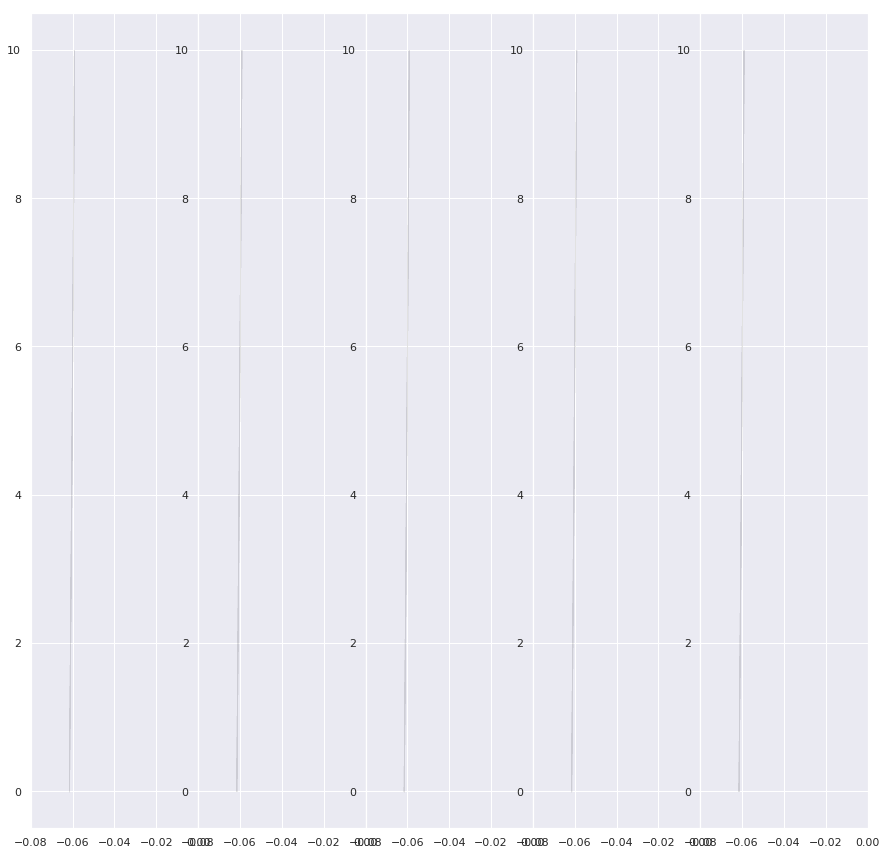

In [20]:
fig, ax = plt.subplots(1,5, figsize=(15,15))
plt.subplots_adjust(wspace=0, hspace=0)

results = []
oscampend = []
oscampmiddle = []
maxim = []
minim = []
for g in range(PROCESSES):
    
    for hh in range(10):
        with open(f'results{hh}{g}.pickle', 'rb') as handle:
            results.append(pickle.load(handle))
            #os.remove(f'results{hh}{g}.pickle')           
    for i in range(len(results)):
        oscampend.append([])
        oscampmiddle.append([])
        minim.append([])
        maxim.append([])
        for ff in range(len(results[0])):
            #plt.plot(results[i][ff][f'population_of_{cell_id}/0/{cell_id}/0/v'])
            #plt.plot(results[i][ff][f'population_of_{cell_id}/0/{cell_id}/0/v'][350000:400000])
            oscampend[len(oscampend)-1].append((max(results[i][ff][f'population_of_{cell_id}/0/{cell_id}/0/v'][350000:400000]) - min(results[i][ff][f'population_of_{cell_id}/0/{cell_id}/0/v'][350000:400000])))
            oscampmiddle[len(oscampmiddle)-1].append((max(results[i][ff][f'population_of_{cell_id}/0/{cell_id}/0/v'][35000:40000]) - min(results[i][ff][f'population_of_{cell_id}/0/{cell_id}/0/v'][35000:40000])))
    
            maxim[len(maxim)-1].append(max(results[i][ff][f'population_of_{cell_id}/0/{cell_id}/0/v'][350000:400000]))
            minim[len(minim)-1].append(min(results[i][ff][f'population_of_{cell_id}/0/{cell_id}/0/v'][350000:400000]))
    
            
            t = np.linspace(0,len(maxim[0]),len(maxim[0]))
        
        ax[g].fill_betweenx(t,maxim[len(maxim)-1],minim[len(maxim)-1], alpha=0.01, color='k')
        ax[g].set_xlim([-0.08, -0.00])
        
    
    results = []
    gc.collect()
    print('RAM memory % used:', psutil.virtual_memory()[2])   

    
    

In [21]:
 %matplotlib inline
resultsmp = None


In [22]:
#maxim = np.array(maxim)
#where_are_NaNs = isnan(maxim)
#maxim[where_are_NaNs] = 0
#thresh = 0.07
#super_threshold_indices = oscamp > thresh
#oscamp[super_threshold_indices] = 0.0

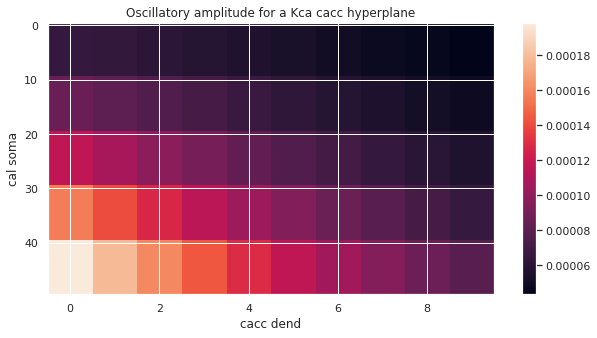

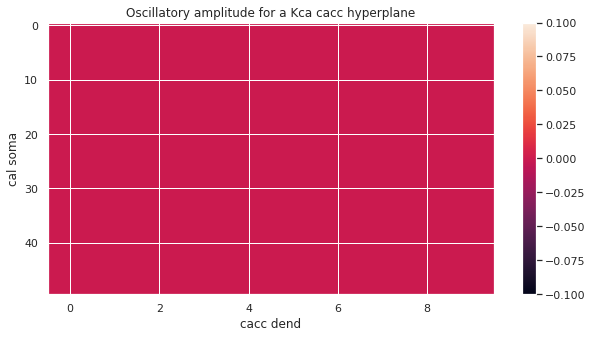

In [23]:
plt.figure(figsize=(10,5))
plt.imshow(oscampmiddle,interpolation='none', aspect='auto')
plt.colorbar()


plt.xlabel('cacc dend')
plt.ylabel('cal soma')
plt.title('Oscillatory amplitude for a Kca cacc hyperplane')
plt.show()


plt.figure(figsize=(10,5))
plt.imshow(oscampend,interpolation='none', aspect='auto')
plt.colorbar()


plt.xlabel('cacc dend')
plt.ylabel('cal soma')
plt.title('Oscillatory amplitude for a Kca cacc hyperplane')
plt.show()

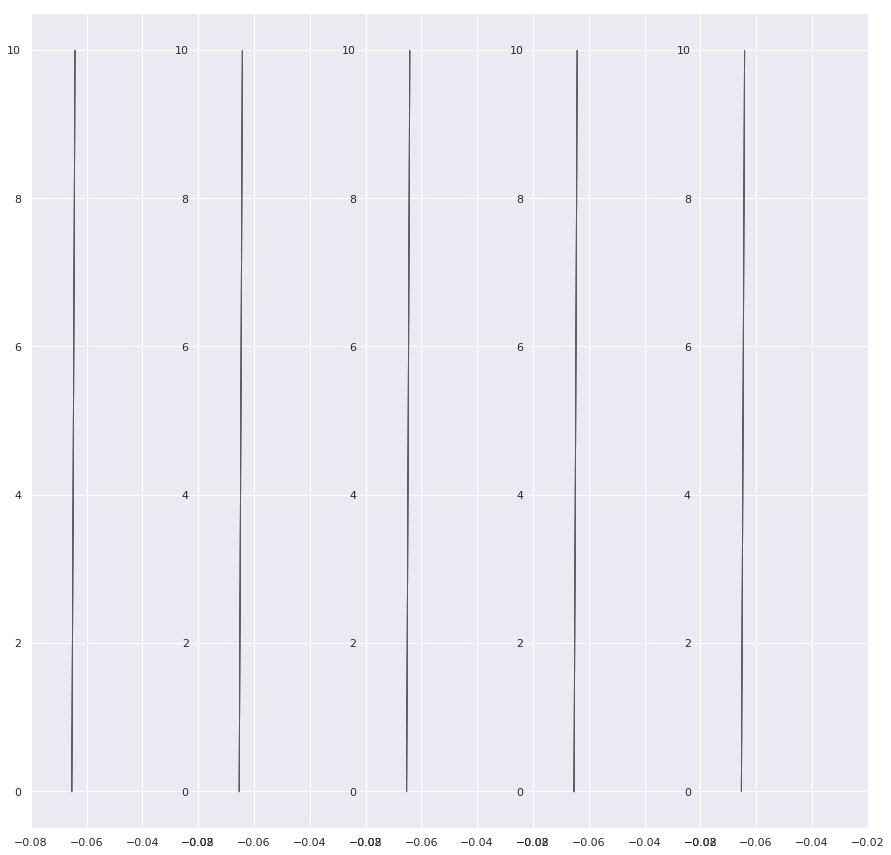

In [292]:
fig, ax = plt.subplots(1,5, figsize=(15,15))
t = np.linspace(0,len(maxim[1]),len(maxim[1]))
#fig.subplots(sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlim([-0.08, -0.02])
for g in range(5):
    for i in range(len(maxim[1])):
        ax[g].fill_betweenx(t,maxim[i],minim[i], alpha=0.1, color='k')
        ax[g].set_xlim([-0.08, -0.02])



In [293]:
minim[1][:]

[-0.06544857,
 -0.06531487,
 -0.06518271,
 -0.06505221,
 -0.06492345,
 -0.06479652,
 -0.06467148,
 -0.0645484,
 -0.06442733,
 -0.06430829]

RAM memory % used: 35.7
RAM memory % used: 41.4
RAM memory % used: 47.2
RAM memory % used: 52.9
RAM memory % used: 58.6


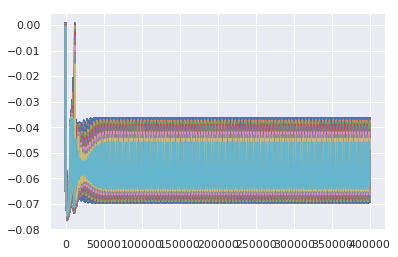

In [30]:
results = []
for g in range(PROCESSES):
    
    for i in range(10):
        with open(f'results{i}{g}.pickle', 'rb') as handle:
            results.append(pickle.load(handle))      
            #os.remove(f'results{i}{g}.pickle')
            
    for i in range(len(results)):
        for ff in range(len(results[1])):
            plt.plot(results[i][ff][f'population_of_{cell_id}/0/{cell_id}/0/v'])
    results = []
    gc.collect()
    print('RAM memory % used:', psutil.virtual_memory()[2])  

In [295]:
plt.figure(figsize=(10,5))
for i in range(len(results)):
    for g in range(len(results[1])):
        plt.plot(results[i][g][f'population_of_{cell_id}/0/{cell_id}/0/v'][21000:40000])

<Figure size 720x360 with 0 Axes>

In [72]:
from numpy import *


amp = np.zeros((len(results),len(results[1])))
maxim = np.zeros((len(results),len(results[1])))
minim = np.zeros((len(results),len(results[1])))
for i in range(len(results)):
    for g in range(len(results[1])):
        amp[i,g] = (max(results[i][g][f'population_of_{cell_id}/0/{cell_id}/0/v'][20000:40000]) - min(results[i][g][f'population_of_{cell_id}/0/{cell_id}/0/v'][20000:40000]))
        maxim[i,g] = max(results[i][g][f'population_of_{cell_id}/0/{cell_id}/0/v'][20000:40000])
        minim[i,g] = min(results[i][g][f'population_of_{cell_id}/0/{cell_id}/0/v'][20000:40000])
where_are_NaNs = isnan(amp)
amp[where_are_NaNs] = 0
thresh = 0.07
super_threshold_indices = amp > thresh
amp[super_threshold_indices] = 0.0

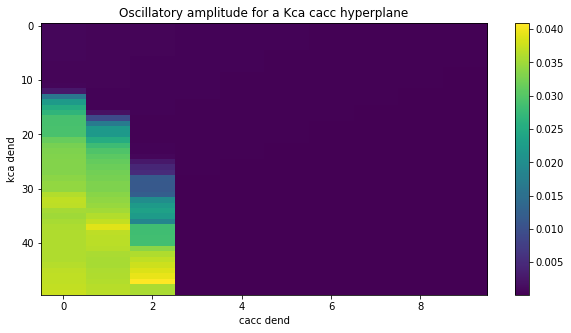

In [73]:
plt.figure(figsize=(10,5))
plt.imshow(amp,interpolation='none', aspect='auto')
plt.colorbar()


plt.xlabel('cacc dend')
plt.ylabel('kca dend')
plt.title('Oscillatory amplitude for a Kca cacc hyperplane')
plt.show()


In [ ]:
x = []
z=[]
y=[]
thresh = 0.05
z = np.zeros((len(results),len(results[1])))
for i in range(len(results)):
    for g in range(len(results[1])):
        z[i,g] = (max(results[i][g][f'population_of_{cell_id}/0/{cell_id}/0/v'][20000:40000]) - min(results[i][g][f'population_of_{cell_id}/0/{cell_id}/0/v'][20000:40000]))
    x.append(np.ones((len(z[0])))*i)
    
       
y = np.linspace(0,len(z[0,:]),len(z[0,:]))


where_are_NaNs = isnan(z)
z[where_are_NaNs] = 0

super_threshold_indices = z > thresh
z[super_threshold_indices] = 0.02

#%matplotlib inline
%matplotlib notebook

In [ ]:

plt.figure(figsize=(15,10))
ax = plt.subplot(projection='3d')

for g in range(len(z)):
    ax.plot_surface(x,y,  z, cmap='viridis', linewidth=0)
    plt.show()
    
ax.set_ylabel('cacc_dend')
ax.set_xlabel('kca_dend')
ax.set_zlabel('Amp(mV)')

In [ ]:
plt.figure(figsize=(10,5))

for g in range(len(results[1])):
    plt.plot(results[1][0]['t'][200000:], results[1][g][f'population_of_{cell_id}/0/{cell_id}/0/v'][200000:])

In [ ]:
from numpy import *
amp = np.zeros((len(results),len(results[1])))
maxim = np.zeros((len(results),len(results[1])))
minim = np.zeros((len(results),len(results[1])))
for i in range(len(results)):
    for g in range(len(results[1])):
        amp[i,g] = (max(results[i][g][f'population_of_{cell_id}/0/{cell_id}/0/v'][200000:]) - min(results[i][g][f'population_of_{cell_id}/0/{cell_id}/0/v'][200000:]))
        maxim[i,g] = max(results[i][g][f'population_of_{cell_id}/0/{cell_id}/0/v'][200000:])
        minim[i,g] = min(results[i][g][f'population_of_{cell_id}/0/{cell_id}/0/v'][200000:])
where_are_NaNs = isnan(amp)
amp[where_are_NaNs] = 0

thresh = 0.06
super_threshold_indices = amp > thresh
amp[super_threshold_indices] = 0


plt.figure(figsize=(10,5))
plt.imshow(amp,interpolation='none', aspect='auto')
plt.colorbar()
plt.show()
ax.set_xlabel('cah_dend')
ax.set_ylabel('kca_dend')

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


RAM memory % used: 14.2
RAM memory % used: 14.6
RAM memory % used: 14.6
RAM memory % used: 14.6
RAM memory % used: 14.6


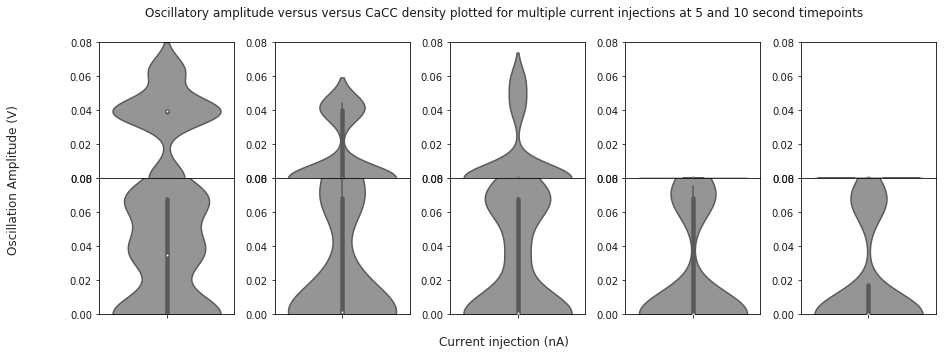

In [8]:
fig, ax = plt.subplots(2,5, figsize=(15,5))
plt.subplots_adjust(wspace=0.3, hspace=0)
plt.suptitle('Oscillatory amplitude versus versus CaCC density plotted for multiple current injections at 5 and 10 second timepoints') 
sns.set(style="darkgrid")
fig.text(0.5, 0.04, 'Current injection (nA)', ha='center')
fig.text(0.04, 0.5, 'Oscillation Amplitude (V)', va='center', rotation='vertical')
plt.setp(ax,ylim=(0,0.08))
results = []
oscampend = []
oscampmiddle = []
maxim = []
minim = []
for g in range(PROCESSES):
    
    for hh in range(10):
        with open(f'results{hh}{g}.pickle', 'rb') as handle:
            results.append(pickle.load(handle))
            #os.remove(f'results{hh}{g}.pickle')           
    for i in range(len(results)):
        oscampend.append([])
        oscampmiddle.append([])
        minim.append([])
        maxim.append([])
        for ff in range(len(results[0])):
            #plt.plot(results[i][ff][f'population_of_{cell_id}/0/{cell_id}/0/v'])
            #plt.plot(results[i][ff][f'population_of_{cell_id}/0/{cell_id}/0/v'][350000:400000])
            oscampend[len(oscampend)-1].append((max(results[i][ff][f'population_of_{cell_id}/0/{cell_id}/0/v'][350000:400000]) - min(results[i][ff][f'population_of_{cell_id}/0/{cell_id}/0/v'][350000:400000])))
            oscampmiddle[len(oscampmiddle)-1].append((max(results[i][ff][f'population_of_{cell_id}/0/{cell_id}/0/v'][35000:40000]) - min(results[i][ff][f'population_of_{cell_id}/0/{cell_id}/0/v'][35000:40000])))

    
    sns.violinplot(oscampmiddle, ax=ax[0][g] ,orient='v', palette='Greys')
    sns.violinplot(oscampend, ax=ax[1][g] ,orient='v', palette='Greys')
         
        
        
    oscampend = []
    oscampmiddle =[]
    results = []
    gc.collect()
    print('RAM memory % used:', psutil.virtual_memory()[2])   
    


In [34]:
maxim = None
minim = None
amp = None
z = None
results = None
oscamp = None